<div class="alert alert-block alert-success" style="text-align:center;">
<center>Formation Data Scientist - Projet n°7 - OpenClassrooms - Christoph Pruvost - avril/mai 2022
    
<center><a href="https://openclassrooms.com/fr/paths/164/projects/632/assignment">https://openclassrooms.com/fr/paths/164/projects/632/assignment</a></center>
<!-- <p></p>
<ul class="last simple">
<li></li> -->
</div>

# Implémentez un modèle de scoring
<div class="admonition note alert alert-info">
    <p class="first admonition-title" style="font-size:25px;font-weight: bold;text-align:center">Analyse exploratoire</p>
<p class="last">&nbsp;
    
<p>Nous sommes Data Scientist au sein d'une société financière, nommée <strong>"Prêt à dépenser"</strong>, &nbsp;qui propose des crédits à la consommation pour des personnes ayant peu ou pas du tout d'historique de prêt.</p>

<p>L’entreprise souhaite <strong>mettre en œuvre un outil de “scoring crédit” pour calculer la probabilité </strong>qu’un client rembourse son crédit, puis classifie la demande en crédit accordé ou refusé. Elle souhaite donc développer un <strong>algorithme de classification</strong> en s’appuyant sur des sources de données variées (données comportementales, données provenant d'autres institutions financières, etc.).</p>
<p>De plus, les chargés de relation client ont fait remonter le fait que les clients sont de plus en plus demandeurs de <strong>transparence</strong> vis-à-vis des décisions d’octroi de crédit. Cette demande de transparence des clients va tout à fait dans le sens des valeurs que l’entreprise veut incarner.</p>
<p><strong>Prêt à dépenser </strong>décide donc de <strong>développer un dashboard interactif</strong> pour que les chargés de relation client puissent à la fois expliquer de façon la plus transparente possible les décisions d’octroi de crédit, mais également permettre à leurs clients de disposer de leurs informations personnelles et de les explorer facilement.</p>
<br><u><b>Les données</b></u>
<p><a href="https://www.kaggle.com/c/home-credit-default-risk/data">Voici les données</a> dont nous aurons besoin pour réaliser le dashboard. Pour plus de simplicité, nous pouvons également les télécharger à <a href="https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/Parcours_data_scientist/Projet+-+Impl%C3%A9menter+un+mod%C3%A8le+de+scoring/Projet+Mise+en+prod+-+home-credit-default-risk.zip">cette adresse</a>.</p>
<br><u><b>Notre mission</b></u>
<ol>
<li>Construire un modèle de scoring qui donnera une prédiction sur la probabilité de faillite d'un client de façon automatique.</li>
<li>Construire un dashboard interactif à destination des gestionnaires de la relation client permettant d'interpréter les prédictions faites par le modèle, et d’améliorer la connaissance client des chargés de relation client.</li>
</ol>
<p><strong>Michaël</strong>, notre manager, nous incite à sélectionner un kernel Kaggle pour nous faciliter la préparation des données nécessaires à l’élaboration du modèle de scoring. Nous analyserons ce kernel et l’adapterons pour nous assurer qu’il répond aux besoins de votre mission. Nous pourrons ainsi nous focaliser sur l’élaboration du modèle, son optimisation et sa compréhension.</p>
&nbsp;
<p>Dans un premier temps, nous allons réaliser ici l'<strong>analyse exploratoire des données</strong>.&nbsp;
</p>
</div>

*L'analyse exploratoire s'appuie sur le kernel Kaggle suivant :*
- https://www.kaggle.com/code/rishabhrao/home-credit-default-risk-extensive-eda/notebook

# Les données
Les données sont constituées de 10 fichiers au format CSV, occupant au total 2.7 Go d'espace disque (0.7 Go compressé dans l'archive regroupant tous les fichiers).

Les fichiers sont liés ensemble par l'identifiant unique client `SK_ID_CURR` de la façon suivante :
![https://storage.googleapis.com/kaggle-media/competitions/home-credit/home_credit.png](https://storage.googleapis.com/kaggle-media/competitions/home-credit/home_credit.png)

Détaillons les fichiers et leur contenu ci-dessous.

## Imports et variables
Importons les librairies nécessaires à notre analyse et définissons quelques variables globales.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import datetime, sys

In [2]:
# Versions des librairies utilisées :
print('Version des librairies utilisées le', datetime.datetime.now(), '\n',
       'Python :', sys.version, '\n',
       'NumPy :',  np.version.full_version, '\n',
       'Pandas :', pd.__version__, '\n',
       'Matplotlib :', mpl.__version__, '\n',
       'Seaborn :', sns.__version__, '\n',
      )

Version des librairies utilisées le 2022-06-06 09:21:50.924959 
 Python : 3.10.4 | packaged by conda-forge | (main, Mar 24 2022, 17:38:57) [GCC 10.3.0] 
 NumPy : 1.22.3 
 Pandas : 1.4.2 
 Matplotlib : 3.5.2 
 Seaborn : 0.11.2 



In [3]:
# Appliquons certaines options globales Pandas et seaborn :
pandas_options = {
    'display.max_rows': 400,
    'display.max_column': 50,
    'display.width': 100,
    'display.max_colwidth': 2000,  # 200
    'display.float_format': '{:,.2f}'.format # arrondi à 2 chiffres après la virgule
}

for cle, valeur in pandas_options.items():
    pd.set_option(cle, valeur)

# Agrandissons les polices d'écriture par défaut :
sns.set(font_scale=1.1)
# Graphiques avec fond blanc :
sns.set_style("white")

In [4]:
def description_rapide(dataframe, df_var_info=None, nom_fichier=None):
    """
    Fonction de description rapide d'un DataFrame, affichant 
    - sa taille,
    - le nombre de ligne duppliquées, le cas échéant,
    - le nombre de valeurs manquantes, le cas échéant
    - les 5 premières lignes du jeu de données.
    - la description des variables si un DataFrame est fourni dans ce but.
    
    Parameters :
    ----------
    - DataFrame à étudier
    - DataFrame décrivant les variables - "None" par défaut : pas de description.
    - Nome du fichier étudié, pour pouvoir filter la description des variables en fonction du nom de fichier.
    
    Returns :
    -------
    - Pas de retour particulier.
    """
    print('─'*50)
    print(f'Taille du jeu de données :{dataframe.shape}')
    print(f'Nombre de lignes duppliquées : {dataframe.shape[0] - dataframe.duplicated().shape[0]}')
    print(f'Nombre de valeurs manquantes : {dataframe.isna().sum().sum()}')
    print(f'% de valeurs manquantes : {dataframe.isna().sum().sum() * 100 / np.product(dataframe.shape):.2f}%')
    print('─'*50)
    if (type(df_var_info).__name__ == 'DataFrame') & (nom_fichier != None):
        print('\nDescription des variables puis aperçu des 5 premières lignes :')
        display(df_var_info.loc[df_var_info['Table'] == nom_fichier,['Row', 'Description', 'Special' ]])
    print('\nAperçu des 5 premières lignes :')
    display(dataframe.head())

## Les fichiers de données

### HomeCredit_columns_description.csv
Ce fichier de 37,4 kB contient la description des colonnes des différents autres fichiers de données.

In [5]:
df_desc = pd.read_csv('.data/HomeCredit_columns_description.csv', encoding='us-ascii', encoding_errors='backslashreplace')

In [6]:
df_desc.head(20).style.hide(axis='index')

Unnamed: 0,Table,Row,Description,Special
1,application_{train|test}.csv,SK_ID_CURR,ID of loan in our sample,nan
2,application_{train|test}.csv,TARGET,"Target variable (1 - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan in our sample, 0 - all other cases)",nan
5,application_{train|test}.csv,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,nan
6,application_{train|test}.csv,CODE_GENDER,Gender of the client,nan
7,application_{train|test}.csv,FLAG_OWN_CAR,Flag if the client owns a car,nan
8,application_{train|test}.csv,FLAG_OWN_REALTY,Flag if client owns a house or flat,nan
9,application_{train|test}.csv,CNT_CHILDREN,Number of children the client has,nan
10,application_{train|test}.csv,AMT_INCOME_TOTAL,Income of the client,nan
11,application_{train|test}.csv,AMT_CREDIT,Credit amount of the loan,nan
12,application_{train|test}.csv,AMT_ANNUITY,Loan annuity,nan


In [7]:
description_rapide(df_desc)

──────────────────────────────────────────────────
Taille du jeu de données :(219, 5)
Nombre de lignes duppliquées : 0
Nombre de valeurs manquantes : 133
% de valeurs manquantes : 12.15%
──────────────────────────────────────────────────

Aperçu des 5 premières lignes :


,Unnamed: 0,Table,Row,Description,Special
0,1,application_{train|test}.csv,SK_ID_CURR,ID of loan in our sample,NaN
1,2,application_{train|test}.csv,TARGET,"Target variable (1 - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan in our sample, 0 - all other cases)",NaN
2,5,application_{train|test}.csv,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,NaN
3,6,application_{train|test}.csv,CODE_GENDER,Gender of the client,NaN
4,7,application_{train|test}.csv,FLAG_OWN_CAR,Flag if the client owns a car,NaN


### application_{train|test}.csv
Les deux fichiers `application_train.csv` (166.1 MB) et `application_test.csv` (26.6 MB) représentent la table principale de la base de données, divisée en deux fichiers:
- l'un pour l'entraînement des données (avec la variable à prédire),
- l'autre pour les tests (sans la variable à prédire).

Une ligne représente une demande de prêt dans notre échantillon de données.

In [8]:
df_train = pd.read_csv('.data/application_train.csv')

In [9]:
df_test = pd.read_csv('.data/application_test.csv')

In [10]:
# Observons le jeu de données d'entraînement :
description_rapide(df_train, df_var_info=df_desc, nom_fichier="application_{train|test}.csv")

──────────────────────────────────────────────────
Taille du jeu de données :(307511, 122)
Nombre de lignes duppliquées : 0
Nombre de valeurs manquantes : 9152465
% de valeurs manquantes : 24.40%
──────────────────────────────────────────────────

Description des variables puis aperçu des 5 premières lignes :


,Row,Description,Special
0,SK_ID_CURR,ID of loan in our sample,NaN
1,TARGET,"Target variable (1 - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan in our sample, 0 - all other cases)",NaN
2,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,NaN
3,CODE_GENDER,Gender of the client,NaN
4,FLAG_OWN_CAR,Flag if the client owns a car,NaN
5,FLAG_OWN_REALTY,Flag if client owns a house or flat,NaN
6,CNT_CHILDREN,Number of children the client has,NaN
7,AMT_INCOME_TOTAL,Income of the client,NaN
8,AMT_CREDIT,Credit amount of the loan,NaN
9,AMT_ANNUITY,Loan annuity,NaN



Aperçu des 5 premières lignes :


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,...,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,"202,500.00","406,597.50","24,700.50","351,000.00",Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.02,-9461,-637,"-3,648.00",-2120,NaN,1,1,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00,1.00
1,100003,0,Cash loans,F,N,N,0,"270,000.00","1,293,502.50","35,698.50","1,129,500.00",Family,State servant,Higher education,Married,House / apartment,0.00,-16765,-1188,"-1,186.00",-291,NaN,1,1,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00,0.00
2,100004,0,Revolving loans,M,Y,Y,0,"67,500.00","135,000.00","6,750.00","135,000.00",Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.01,-19046,-225,"-4,260.00",-2531,26.00,1,1,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00,0.00
3,100006,0,Cash loans,F,N,Y,0,"135,000.00","312,682.50","29,686.50","297,000.00",Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.01,-19005,-3039,"-9,833.00",-2437,NaN,1,1,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,"121,500.00","513,000.00","21,865.50","513,000.00",Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.03,-19932,-3038,"-4,311.00",-3458,NaN,1,1,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00,0.00


In [11]:
# Observons quelques statistiques descriptives des données quantitatives :
df_train.describe(include=np.number)

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,...,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,"307,511.00","307,511.00","307,511.00","307,511.00","307,511.00","307,499.00","307,233.00","307,511.00","307,511.00","307,511.00","307,511.00","307,511.00","104,582.00","307,511.00","307,511.00","307,511.00","307,511.00","307,511.00","307,511.00","307,509.00","307,511.00","307,511.00","307,511.00","307,511.00","307,511.00",...,"307,511.00","307,511.00","307,511.00","307,511.00","307,511.00","307,511.00","307,511.00","307,511.00","307,511.00","307,511.00","307,511.00","307,511.00","307,511.00","307,511.00","307,511.00","307,511.00","307,511.00","307,511.00","307,511.00","265,992.00","265,992.00","265,992.00","265,992.00","265,992.00","265,992.00"
mean,"278,180.52",0.08,0.42,"168,797.92","599,026.00","27,108.57","538,396.21",0.02,"-16,037.00","63,815.05","-4,986.12","-2,994.20",12.06,1.00,0.82,0.20,1.00,0.28,0.06,2.15,2.05,2.03,12.06,0.02,0.05,...,0.71,0.00,0.02,0.09,0.00,0.08,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.01,0.00,0.00,0.00,0.01,0.01,0.03,0.27,0.27,1.90
std,"102,790.18",0.27,0.72,"237,123.15","402,490.78","14,493.74","369,446.46",0.01,"4,363.99","141,275.77","3,522.89","1,509.45",11.94,0.00,0.38,0.40,0.04,0.45,0.23,0.91,0.51,0.50,3.27,0.12,0.22,...,0.45,0.01,0.12,0.28,0.01,0.27,0.06,0.00,0.06,0.00,0.06,0.05,0.03,0.10,0.02,0.09,0.02,0.02,0.02,0.08,0.11,0.20,0.92,0.79,1.87
min,"100,002.00",0.00,0.00,"25,650.00","45,000.00","1,615.50","40,500.00",0.00,"-25,229.00","-17,912.00","-24,672.00","-7,197.00",0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,1.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,"189,145.50",0.00,0.00,"112,500.00","270,000.00","16,524.00","238,500.00",0.01,"-19,682.00","-2,760.00","-7,479.50","-4,299.00",5.00,1.00,1.00,0.00,1.00,0.00,0.00,2.00,2.00,2.00,10.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,"278,202.00",0.00,0.00,"147,150.00","513,531.00","24,903.00","450,000.00",0.02,"-15,750.00","-1,213.00","-4,504.00","-3,254.00",9.00,1.00,1.00,0.00,1.00,0.00,0.00,2.00,2.00,2.00,12.00,0.00,0.00,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
75%,"367,142.50",0.00,1.00,"202,500.00","808,650.00","34,596.00","679,500.00",0.03,"-12,413.00",-289.00,"-2,010.00","-1,720.00",15.00,1.00,1.00,0.00,1.00,1.00,0.00,3.00,2.00,2.00,14.00,0.00,0.00,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,3.00
max,"456,255.00",1.00,19.00,"117,000,000.00","4,050,000.00","258,025.50","4,050,000.00",0.07,"-7,489.00","365,243.00",0.00,0.00,91.00,1.00,1.00,1.00,1.00,1.00,1.00,20.00,3.00,3.00,23.00,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,4.00,9.00,8.00,27.00,261.00,25.00


In [12]:
# Observons quelques statistiques descriptives des données qualitatives :
df_train.describe(exclude=np.number)

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE,FONDKAPREMONT_MODE,HOUSETYPE_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE
count,307511,307511,307511,307511,306219,307511,307511,307511,307511,211120,307511,307511,97216,153214,151170,161756
unique,2,3,2,2,7,8,5,6,6,18,7,58,4,3,7,2
top,Cash loans,F,N,Y,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,Laborers,TUESDAY,Business Entity Type 3,reg oper account,block of flats,Panel,No
freq,278232,202448,202924,213312,248526,158774,218391,196432,272868,55186,53901,67992,73830,150503,66040,159428


In [13]:
# Observons le jeu de données de test :
description_rapide(df_test)

──────────────────────────────────────────────────
Taille du jeu de données :(48744, 121)
Nombre de lignes duppliquées : 0
Nombre de valeurs manquantes : 1404419
% de valeurs manquantes : 23.81%
──────────────────────────────────────────────────

Aperçu des 5 premières lignes :


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,...,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,"135,000.00","568,800.00","20,560.50","450,000.00",Unaccompanied,Working,Higher education,Married,House / apartment,0.02,-19241,-2329,"-5,170.00",-812,NaN,1,1,0,1,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00,0.00
1,100005,Cash loans,M,N,Y,0,"99,000.00","222,768.00","17,370.00","180,000.00",Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.04,-18064,-4469,"-9,118.00",-1623,NaN,1,1,0,1,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00,3.00
2,100013,Cash loans,M,Y,Y,0,"202,500.00","663,264.00","69,777.00","630,000.00",NaN,Working,Higher education,Married,House / apartment,0.02,-20038,-4458,"-2,175.00",-3503,5.00,1,1,0,1,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,1.00,4.00
3,100028,Cash loans,F,N,Y,2,"315,000.00","1,575,000.00","49,018.50","1,575,000.00",Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.03,-13976,-1866,"-2,000.00",-4208,NaN,1,1,0,1,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00,3.00
4,100038,Cash loans,M,Y,N,1,"180,000.00","625,500.00","32,067.00","625,500.00",Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.01,-13040,-2191,"-4,000.00",-4262,16.00,1,1,1,1,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
print(f'df_test représente {df_test.shape[0]*100/df_train.shape[0]:0.2f}% des données de df_train et contient',
      f"{df_train.shape[1] - df_test.shape[1]} colonnes de moins (la variable à prédire en l'occurrence).")

df_test représente 15.85% des données de df_train et contient 1 colonnes de moins (la variable à prédire en l'occurrence).


In [15]:
df_train.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 122 columns):
 #    Column                        Dtype  
---   ------                        -----  
 0    SK_ID_CURR                    int64  
 1    TARGET                        int64  
 2    NAME_CONTRACT_TYPE            object 
 3    CODE_GENDER                   object 
 4    FLAG_OWN_CAR                  object 
 5    FLAG_OWN_REALTY               object 
 6    CNT_CHILDREN                  int64  
 7    AMT_INCOME_TOTAL              float64
 8    AMT_CREDIT                    float64
 9    AMT_ANNUITY                   float64
 10   AMT_GOODS_PRICE               float64
 11   NAME_TYPE_SUITE               object 
 12   NAME_INCOME_TYPE              object 
 13   NAME_EDUCATION_TYPE           object 
 14   NAME_FAMILY_STATUS            object 
 15   NAME_HOUSING_TYPE             object 
 16   REGION_POPULATION_RELATIVE    float64
 17   DAYS_BIRTH                    int64  
 18   DA

In [16]:
df_test.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48744 entries, 0 to 48743
Data columns (total 121 columns):
 #    Column                        Dtype  
---   ------                        -----  
 0    SK_ID_CURR                    int64  
 1    NAME_CONTRACT_TYPE            object 
 2    CODE_GENDER                   object 
 3    FLAG_OWN_CAR                  object 
 4    FLAG_OWN_REALTY               object 
 5    CNT_CHILDREN                  int64  
 6    AMT_INCOME_TOTAL              float64
 7    AMT_CREDIT                    float64
 8    AMT_ANNUITY                   float64
 9    AMT_GOODS_PRICE               float64
 10   NAME_TYPE_SUITE               object 
 11   NAME_INCOME_TYPE              object 
 12   NAME_EDUCATION_TYPE           object 
 13   NAME_FAMILY_STATUS            object 
 14   NAME_HOUSING_TYPE             object 
 15   REGION_POPULATION_RELATIVE    float64
 16   DAYS_BIRTH                    int64  
 17   DAYS_EMPLOYED                 int64  
 18   DAYS

In [17]:
# Observons quelques statistiques descriptives :
df_test.describe(include=np.number)

,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,...,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,"48,744.00","48,744.00","48,744.00","48,744.00","48,720.00","48,744.00","48,744.00","48,744.00","48,744.00","48,744.00","48,744.00","16,432.00","48,744.00","48,744.00","48,744.00","48,744.00","48,744.00","48,744.00","48,744.00","48,744.00","48,744.00","48,744.00","48,744.00","48,744.00","48,744.00",...,"48,744.00","48,744.00","48,744.00","48,744.00","48,744.00","48,744.00","48,744.00","48,744.00","48,744.00","48,744.00","48,744.00","48,744.00","48,744.00","48,744.00","48,744.00","48,744.00","48,744.00","48,744.00","48,744.00","42,695.00","42,695.00","42,695.00","42,695.00","42,695.00","42,695.00"
mean,"277,796.68",0.40,"178,431.81","516,740.44","29,426.24","462,618.84",0.02,"-16,068.08","67,485.37","-4,967.65","-3,051.71",11.79,1.00,0.81,0.20,1.00,0.26,0.16,2.15,2.04,2.01,12.01,0.02,0.06,0.04,...,0.79,0.00,0.01,0.09,0.00,0.09,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.55,1.98
std,"103,169.55",0.71,"101,522.59","365,397.00","16,016.37","336,710.22",0.01,"4,325.90","144,348.51","3,552.61","1,569.28",11.46,0.00,0.39,0.40,0.04,0.44,0.37,0.89,0.52,0.52,3.28,0.14,0.23,0.20,...,0.41,0.01,0.12,0.28,0.01,0.28,0.07,0.00,0.03,0.00,0.00,0.00,0.00,0.00,0.00,0.04,0.00,0.00,0.00,0.05,0.05,0.05,0.11,0.69,1.84
min,"100,001.00",0.00,"26,941.50","45,000.00","2,295.00","45,000.00",0.00,"-25,195.00","-17,463.00","-23,722.00","-6,348.00",0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,-1.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,"188,557.75",0.00,"112,500.00","260,640.00","17,973.00","225,000.00",0.01,"-19,637.00","-2,910.00","-7,459.25","-4,448.00",4.00,1.00,1.00,0.00,1.00,0.00,0.00,2.00,2.00,2.00,10.00,0.00,0.00,0.00,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,"277,549.00",0.00,"157,500.00","450,000.00","26,199.00","396,000.00",0.02,"-15,785.00","-1,293.00","-4,490.00","-3,234.00",9.00,1.00,1.00,0.00,1.00,0.00,0.00,2.00,2.00,2.00,12.00,0.00,0.00,0.00,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2.00
75%,"367,555.50",1.00,"225,000.00","675,000.00","37,390.50","630,000.00",0.03,"-12,496.00",-296.00,"-1,901.00","-1,706.00",15.00,1.00,1.00,0.00,1.00,1.00,0.00,3.00,2.00,2.00,14.00,0.00,0.00,0.00,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,3.00
max,"456,250.00",20.00,"4,410,000.00","2,245,500.00","180,576.00","2,245,500.00",0.07,"-7,338.00","365,243.00",0.00,0.00,74.00,1.00,1.00,1.00,1.00,1.00,1.00,21.00,3.00,3.00,23.00,1.00,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,2.00,2.00,2.00,6.00,7.00,17.00


In [18]:
# Observons quelques statistiques descriptives :
df_test.describe(exclude=np.number)

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE,FONDKAPREMONT_MODE,HOUSETYPE_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE
count,48744,48744,48744,48744,47833,48744,48744,48744,48744,33139,48744,48744,15947,25125,24851,26535
unique,2,2,2,2,7,7,5,5,6,18,7,58,4,3,7,2
top,Cash loans,F,N,Y,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,Laborers,TUESDAY,Business Entity Type 3,reg oper account,block of flats,Panel,No
freq,48305,32678,32311,33658,39727,24533,33988,32283,43645,8655,9751,10840,12124,24659,11269,26179


In [19]:
def nan_df_create(data):
    '''
    Function créant un DataFrame du pourcentage de NaN pour chaque variable du DataFrame en argument.
    
    Parameters :
    ----------
    - data: DataFrame à étudier
    
    Returns:
    -------
    - DataFrame avec le pourcentage de NaN.
    '''
    nan_percentages = data.isna().sum() * 100 / data.shape[0]
    df = pd.DataFrame({'variable' : nan_percentages.index, 'pourcentage' : nan_percentages.values})
    df.sort_values(by = 'pourcentage', ascending = False, inplace = True)
    return df

In [20]:
def plot_nan_percent(dataframe,
                     title_name,
                     tight_layout = True,
                     figsize = (20,8),
                     grid = False,
                     rotation = 45,
                     ha = 'right'):
    '''
    Fonction d'affichage des valeurs manquantes pour chaque variable avec un histogramme et une carte de chaleur.
        
    Parameters :
    ----------
        df: 
            DataFrame
        title_name: 
            Name of table to be displayed in title of plot
        tight_layout: bool, default = True
            Whether to keep tight layout or not
        figsize: tuple, default = (20,8)
            Figure size of plot    
        grid: bool, default = False
            Whether to draw gridlines to plot or not
        rotation: int, default = 45
            Degree of rotation for x-tick labels
        ha : 
            horizontal alignment : default = right.
    Returns :
    -------
    - None

    '''
    
    #checking if there is any column with NaNs or not.
    df_nan = nan_df_create(dataframe)
    if df_nan.pourcentage.sum() != 0:
        print(f"Nombre de colonnes avec des valeurs manquantes :{df_nan[df_nan['pourcentage'] != 0].shape[0]}")
        #plotting the Bar-Plot for NaN percentages (only for columns with Non-Zero percentage of NaN values)
        plt.figure(figsize = figsize, tight_layout = tight_layout)
        sns.barplot(x= 'variable', y = 'pourcentage', data = df_nan[df_nan['pourcentage'] > 0])
        plt.xticks(rotation = rotation, ha = ha)
        plt.xlabel('Variable')
        plt.ylabel('Pourcentage de valeurs manquantes')
        plt.title(f'Pourcentage de valeurs manquantes dans {title_name} par ordre décroissant', fontsize=15)
        if grid:
            plt.grid()
        plt.show()
        # Observons les valeurs manquantes de l'ensemble du jeu de données à l'aide d'une Heatmap.
        # (En bleu foncé les valeurs présentes, en bleu clair les valeurs absentes)
        plt.figure(figsize = figsize, tight_layout = tight_layout)
        sns.heatmap(dataframe.isna(), cbar=False, cmap="Blues_r")
        plt.xticks(rotation = rotation, ha = ha)
        plt.title(f'Valeurs manquantes dans {title_name} (valeurs présentes en bleu)', fontsize=15)
        plt.show()
            
# sns.set(font_scale = 1) # On passe à une police d'écriture plus fine pour ce graphique chargé.
# plt.show()
# sns.set(font_scale = 1.1)

    else:
        print(f"Le dataframe {title_name} ne contient pas de valeurs manquantes.")

In [21]:
def diagramme_dtypes(dataframe, palette = "flare"):
    """
    Fonction de représentation graphique en diagramme circulaire des types de données jeu de données.
    
    Parameters :
    ----------
    - dataframe : données
    
    Returns :
    -------
    - Graphique
    """
    colors = sns.color_palette(palette)
    explode = [0.05,0.05,0.05]
    dataframe.dtypes.value_counts().plot.pie(
        explode=explode,
        colors=colors,
        autopct='%.0f%%',
        textprops={'fontsize': 12, 'color': 'black'})
    plt.ylabel('')
    plt.title("Répartition des types de variables du jeu de données:",fontsize=14)
    return plt.show()

Nombre de colonnes avec des valeurs manquantes :67


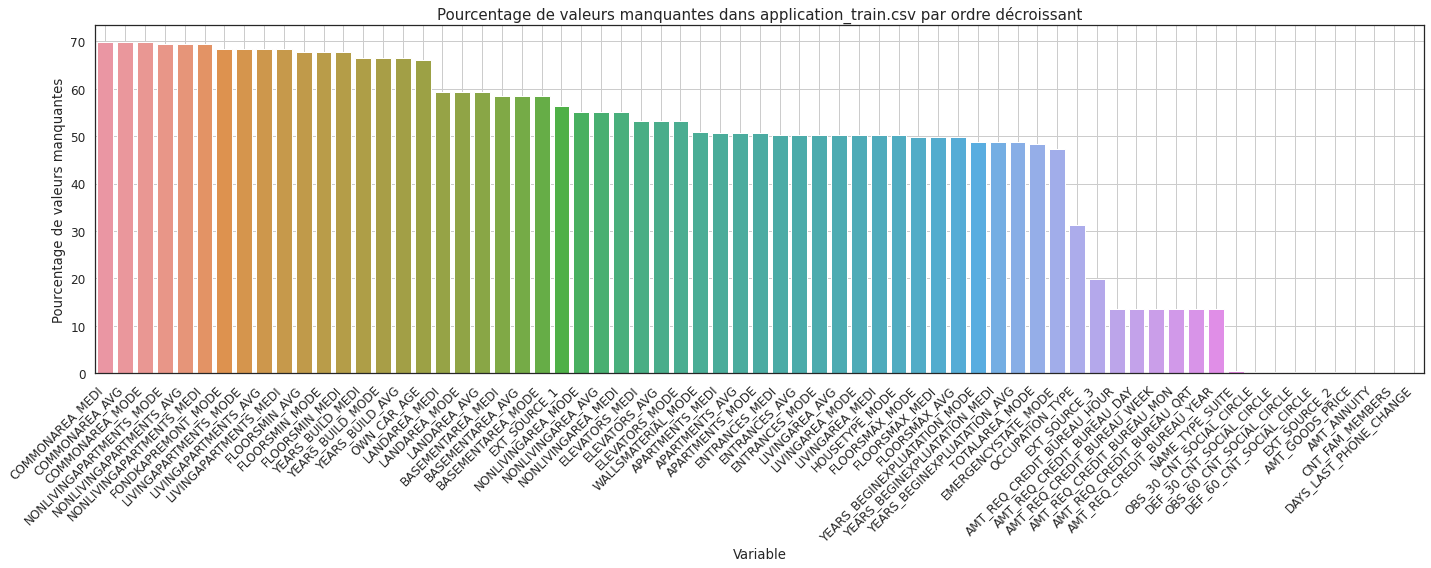

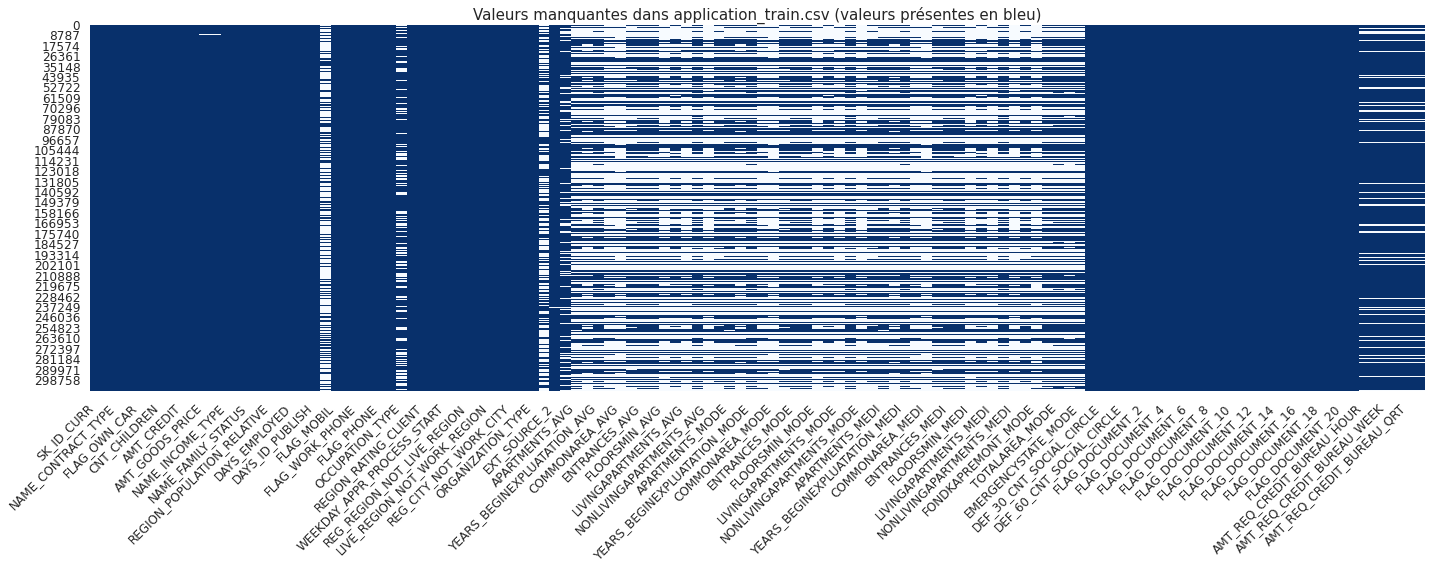

In [22]:
# Observons le pourcentage de valeurs manquantes dans le jeu de données de d'entraînement :
plot_nan_percent(df_train, 'application_train.csv', grid = True)

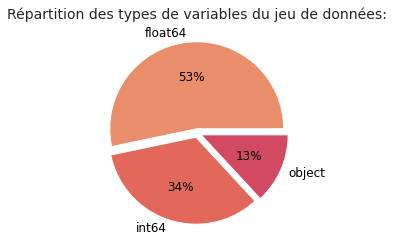

In [23]:
# Observons la répartition des types de données :
diagramme_dtypes(df_train)

Nombre de colonnes avec des valeurs manquantes :64


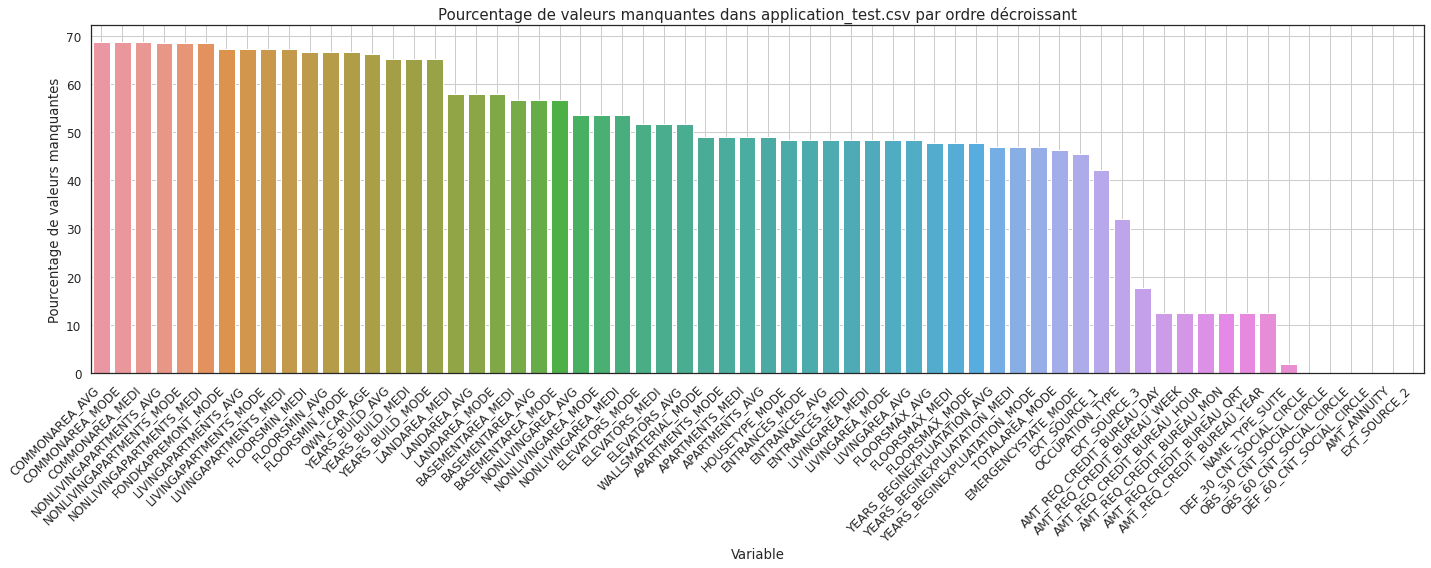

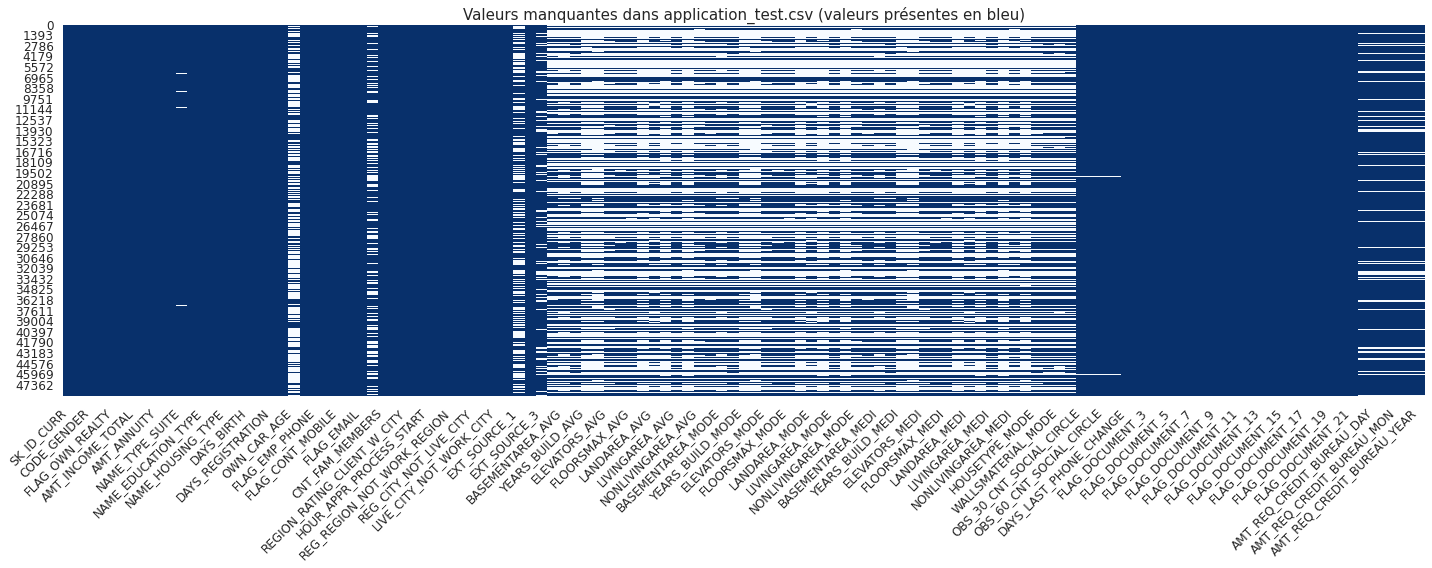

In [24]:
# Observons le pourcentage de valeurs manquantes dans le jeu de données de test :
plot_nan_percent(df_test, 'application_test.csv', grid = True)

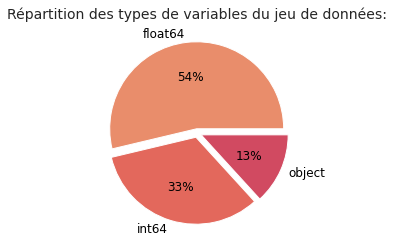

In [25]:
diagramme_dtypes(df_test)

**Synthèse**

- application_train.csv :
 - contient 307511 lignes et 122 variables,
 - ne contient pas de doublons,
 - contient 24.4% de valeurs manquantes, provenant de 67 variables. Certaines variables contiennent jusqu'à 70% de valeurs manquantes,
 - chaque ligne représente une demandes de prêt unique, avec les informations disponibles sur le demandeur (âge, revenu, type de prêt, etc.)
 - la variable TARGET identifie un client avec des difficultées de paiement (valeur à 1), c'est à dire qui a eu un paiement un retard de plus de X jours à au moins une occasion au cours des Y premières échéances de remboursement du prêt (valeur à 0 dans les autres cas).
- application_test.csv:
 - contient  48744 lignes et 121 variables, soit 15,85% des données d'entraînement.
 - il s'agit des mêmes variables que pour le fichier application_train.csv à l'exception de `TARGET`, dans la mesure où il s'agit d'un jeu de données de test.
 - ne contient pas de doublons,
 - contient 23,81% de valeurs manquantes provenant de 64 variables, soit une répartition équivalante au jeu de données d'entraînement.

### bureau.csv
Ce fichier de 170 MB contient tous les crédits précédents proposés aux clients par d'autres institutions financières et rapportés au bureau d'information sur le crédit (BIC) (pour les clients ayant un prêt dans notre échantillon). 

Pour chaque prêt dans notre échantillon, il y a autant de lignes que de nombre de prêts inscrits au bureau d'information sur le crédit avant la date d'ouverture du dossier.

In [26]:
df_bur = pd.read_csv('.data/bureau.csv')

In [27]:
description_rapide(df_bur, df_var_info=df_desc, nom_fichier="bureau.csv")

──────────────────────────────────────────────────
Taille du jeu de données :(1716428, 17)
Nombre de lignes duppliquées : 0
Nombre de valeurs manquantes : 3939947
% de valeurs manquantes : 13.50%
──────────────────────────────────────────────────

Description des variables puis aperçu des 5 premières lignes :


,Row,Description,Special
122,SK_ID_CURR,"ID of loan in our sample - one loan in our sample can have 0,1,2 or more related previous credits in credit bureau",hashed
123,SK_BUREAU_ID,Recoded ID of previous Credit Bureau credit related to our loan (unique coding for each loan application),hashed
124,CREDIT_ACTIVE,Status of the Credit Bureau (CB) reported credits,NaN
125,CREDIT_CURRENCY,Recoded currency of the Credit Bureau credit,recoded
126,DAYS_CREDIT,How many days before current application did client apply for Credit Bureau credit,time only relative to the application
127,CREDIT_DAY_OVERDUE,Number of days past due on CB credit at the time of application for related loan in our sample,NaN
128,DAYS_CREDIT_ENDDATE,Remaining duration of CB credit (in days) at the time of application in Home Credit,time only relative to the application
129,DAYS_ENDDATE_FACT,Days since CB credit ended at the time of application in Home Credit (only for closed credit),time only relative to the application
130,AMT_CREDIT_MAX_OVERDUE,Maximal amount overdue on the Credit Bureau credit so far (at application date of loan in our sample),NaN
131,CNT_CREDIT_PROLONG,How many times was the Credit Bureau credit prolonged,NaN



Aperçu des 5 premières lignes :


,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.00,-153.00,NaN,0,"91,323.00",0.00,NaN,0.00,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,"1,075.00",NaN,NaN,0,"225,000.00","171,342.00",NaN,0.00,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.00,NaN,NaN,0,"464,323.50",NaN,NaN,0.00,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,"90,000.00",NaN,NaN,0.00,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,"1,197.00",NaN,"77,674.50",0,"2,700,000.00",NaN,NaN,0.00,Consumer credit,-21,NaN


In [28]:
# Observons le type des variables :
df_bur.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1716428 entries, 0 to 1716427
Data columns (total 17 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_CURR              int64  
 1   SK_ID_BUREAU            int64  
 2   CREDIT_ACTIVE           object 
 3   CREDIT_CURRENCY         object 
 4   DAYS_CREDIT             int64  
 5   CREDIT_DAY_OVERDUE      int64  
 6   DAYS_CREDIT_ENDDATE     float64
 7   DAYS_ENDDATE_FACT       float64
 8   AMT_CREDIT_MAX_OVERDUE  float64
 9   CNT_CREDIT_PROLONG      int64  
 10  AMT_CREDIT_SUM          float64
 11  AMT_CREDIT_SUM_DEBT     float64
 12  AMT_CREDIT_SUM_LIMIT    float64
 13  AMT_CREDIT_SUM_OVERDUE  float64
 14  CREDIT_TYPE             object 
 15  DAYS_CREDIT_UPDATE      int64  
 16  AMT_ANNUITY             float64
dtypes: float64(8), int64(6), object(3)
memory usage: 222.6+ MB


In [29]:
df_bur.describe(include=np.number)

,SK_ID_CURR,SK_ID_BUREAU,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
count,"1,716,428.00","1,716,428.00","1,716,428.00","1,716,428.00","1,610,875.00","1,082,775.00","591,940.00","1,716,428.00","1,716,415.00","1,458,759.00","1,124,648.00","1,716,428.00","1,716,428.00","489,637.00"
mean,"278,214.93","5,924,434.49","-1,142.11",0.82,510.52,"-1,017.44","3,825.42",0.01,"354,994.59","137,085.12","6,229.51",37.91,-593.75,"15,712.76"
std,"102,938.56","532,265.73",795.16,36.54,"4,994.22",714.01,"206,031.61",0.10,"1,149,811.34","677,401.13","45,032.03","5,937.65",720.75,"325,826.95"
min,"100,001.00","5,000,000.00","-2,922.00",0.00,"-42,060.00","-42,023.00",0.00,0.00,0.00,"-4,705,600.32","-586,406.11",0.00,"-41,947.00",0.00
25%,"188,866.75","5,463,953.75","-1,666.00",0.00,"-1,138.00","-1,489.00",0.00,0.00,"51,300.00",0.00,0.00,0.00,-908.00,0.00
50%,"278,055.00","5,926,303.50",-987.00,0.00,-330.00,-897.00,0.00,0.00,"125,518.50",0.00,0.00,0.00,-395.00,0.00
75%,"367,426.00","6,385,681.25",-474.00,0.00,474.00,-425.00,0.00,0.00,"315,000.00","40,153.50",0.00,0.00,-33.00,"13,500.00"
max,"456,255.00","6,843,457.00",0.00,"2,792.00","31,199.00",0.00,"115,987,185.00",9.00,"585,000,000.00","170,100,000.00","4,705,600.32","3,756,681.00",372.00,"118,453,423.50"


In [30]:
df_bur.describe(exclude=np.number)

,CREDIT_ACTIVE,CREDIT_CURRENCY,CREDIT_TYPE
count,1716428,1716428,1716428
unique,4,4,15
top,Closed,currency 1,Consumer credit
freq,1079273,1715020,1251615



### bureau_balance.csv
375.6 MB
- Monthly balances of previous credits in Credit Bureau.
- This table has one row for each month of history of every previous credit reported to Credit Bureau – i.e the table has (#loans in sample * # of relative previous credits * # of months where we have some history observable for the previous credits) rows.

### POS_CASH_balance.csv
392.7 MB
- Monthly balance snapshots of previous POS (point of sales) and cash loans that the applicant had with Home Credit.
- This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credits * # of months in which we have some history observable for the previous credits) rows.

### credit_card_balance.csv
424.6 MB
- Monthly balance snapshots of previous credit cards that the applicant has with Home Credit.
- This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credit cards * # of months where we have some history observable for the previous credit card) rows.

### previous_application.csv
405 MB
- All previous applications for Home Credit loans of clients who have loans in our sample.
- There is one row for each previous application related to loans in our data sample.

### installments_payments.csv
723.1 MB
- Repayment history for the previously disbursed credits in Home Credit related to the loans in our sample.
- There is a) one row for every payment that was made plus b) one row each for missed payment.
- One row is equivalent to one payment of one installment OR one installment corresponding to one payment of one previous Home Credit credit related to loans in our sample.

## Analyse univariées

### Distribution variable cible

From the distribution of Target variable, one thing that we can quickly notice is the Data Imbalance. There are only 8.07% of the total loans that had actually been Defaulted. This means that Defaulters is the minority class.
On the other hand, there are 91.9% loans which were not Defaulted. Thus, Non-Defaulters will be our majority class.
The Defaulters have been assigned a Target variable of 1 and Non-Defaulters have been assigned Target Variable 0.
For imbalanced dataset, during building the model, we cannot feed the data as is to some algorithms, which are imbalance sensitive.
Similar is the case with the Performance Metrics. For such a dataset, Accuracy is usually not the right metric as the Accuracy would generally be biased to majority class. We can use other metrics such as ROC-AUC Score, Log-Loss, F1-Score, Confusion Matrix for better evaluation of model.
One more important thing to note here is that there are very few people who actually default, and they tend to show some sort of different behaviour. Thus in such cases of Fraud, Default and Anamoly Detection, we need to focus on outliers too, and we cannot remove them, as they could be the differentiating factor between Defaulter and Non-Defaulter.

## Poursuite de l'analyse exploratoire des données

En raison de la quantité de travail importante à fournir pour le P7 et du temps limité disponible pour le réaliser, l'analyse exploratoire n'a pas pu être poursuivie et détaillée ici.

Plus d'informations sont disponibles à l'adresse ci dessous :
- https://www.kaggle.com/code/rishabhrao/home-credit-default-risk-extensive-eda/notebook